In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
! kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

100% 34.0M/34.1M [00:01<00:00, 44.9MB/s]
100% 34.1M/34.1M [00:01<00:00, 31.4MB/s]


In [ ]:
! unzip /content/alzheimers-dataset-4-class-of-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/m

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os
import tqdm
import glob
import tensorflow

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
import numpy as np

def grey2rgb(image):
    # Add empty channels axis to grayscale images
    return np.repeat(image[..., np.newaxis], 3, axis=-1)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
import os
import pandas as pd
from tqdm import tqdm

images = []
labels = []

main_folder = r'/content/Alzheimer_s Dataset/train'
subfolders = ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']

for subfolder in tqdm(subfolders):
    subfolder_path = os.path.join(main_folder, subfolder)
    if os.path.isdir(subfolder_path):
        for image_filename in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_filename)
            images.append(image_path)
            labels.append(subfolder)

df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 4/4 [00:00<00:00, 422.69it/s]


,image,label
0,/content/Alzheimer_s Dataset/train/MildDemente...,MildDemented
1,/content/Alzheimer_s Dataset/train/MildDemente...,MildDemented
2,/content/Alzheimer_s Dataset/train/MildDemente...,MildDemented
3,/content/Alzheimer_s Dataset/train/MildDemente...,MildDemented
4,/content/Alzheimer_s Dataset/train/MildDemente...,MildDemented
...,...,...
5116,/content/Alzheimer_s Dataset/train/VeryMildDem...,VeryMildDemented
5117,/content/Alzheimer_s Dataset/train/VeryMildDem...,VeryMildDemented
5118,/content/Alzheimer_s Dataset/train/VeryMildDem...,VeryMildDemented
5119,/content/Alzheimer_s Dataset/train/VeryMildDem...,VeryMildDemented


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255)
train_dataset  = train_datagen.flow_from_dataframe(df,x_col='image',y_col='label',target_size = (224,224), class_mode = 'categorical',subset = 'training',batch_size = 6500)

Found 5121 validated image filenames belonging to 4 classes.


In [ ]:
train_data, train_labels = next(train_dataset)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_data,train_labels, test_size=0.3, random_state=42,shuffle=True,stratify=train_labels)

In [ ]:
base_model = DenseNet169(input_shape=(224,224,3),
                         include_top=False,
                         weights="imagenet")

51877672/51877672 [==============================] - 2s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable=False

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.applications import DenseNet169

# Define input shape
input_shape = (224, 224, 3)
inputs = Input(shape=input_shape)

# Build the base model
base_model = DenseNet169(input_shape=input_shape,
                         include_top=False,
                         weights="imagenet")

for layer in base_model.layers:
    layer.trainable = False

x = base_model(inputs)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(2048, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)

# Create the model
model = tf.keras.Model(inputs, outputs)

# Define optimizer with learning rate
OPT = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')],
              optimizer=OPT)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 dropout (Dropout)           (None, 81536)             0         
                                                                 
 batch_normalization (Batch  (None, 81536)             326144    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 2048)              166987776 
                                                             

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_cb = ModelCheckpoint("/kaggle/working/model_smote.keras", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[checkpoint_cb, early_stopping_cb])


Epoch 1/100
112/112 [==============================] - 45s 263ms/step - loss: 1.0331 - accuracy: 0.6275 - val_loss: 0.9763 - val_accuracy: 0.6825
Epoch 2/100
112/112 [==============================] - 22s 199ms/step - loss: 0.4625 - accuracy: 0.8278 - val_loss: 0.4416 - val_accuracy: 0.8269
Epoch 3/100
112/112 [==============================] - 22s 194ms/step - loss: 0.2885 - accuracy: 0.8951 - val_loss: 0.3731 - val_accuracy: 0.8653
Epoch 4/100
112/112 [==============================] - 24s 212ms/step - loss: 0.2337 - accuracy: 0.9079 - val_loss: 0.2849 - val_accuracy: 0.9057
Epoch 5/100
112/112 [==============================] - 25s 223ms/step - loss: 0.1873 - accuracy: 0.9339 - val_loss: 0.2470 - val_accuracy: 0.9141
Epoch 6/100
112/112 [==============================] - 22s 199ms/step - loss: 0.1297 - accuracy: 0.9526 - val_loss: 0.1966 - val_accuracy: 0.9284
Epoch 7/100
112/112 [==============================] - 9s 79ms/step - loss: 0.1189 - accuracy: 0.9579 - val_loss: 0.2158 - v

In [ ]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,1.033098,0.627511,0.976325,0.682498
1,0.462542,0.827846,0.441601,0.826936
2,0.288512,0.895089,0.373065,0.865322
3,0.233730,0.907924,0.284886,0.905660
4,0.187301,0.933873,0.246984,0.914118
5,0.129683,0.952567,0.196641,0.928432
6,0.118867,0.957868,0.215841,0.926480
7,0.126473,0.951730,0.200500,0.932986
8,0.124190,0.953404,0.200418,0.934938
9,0.089199,0.966518,0.204774,0.937541


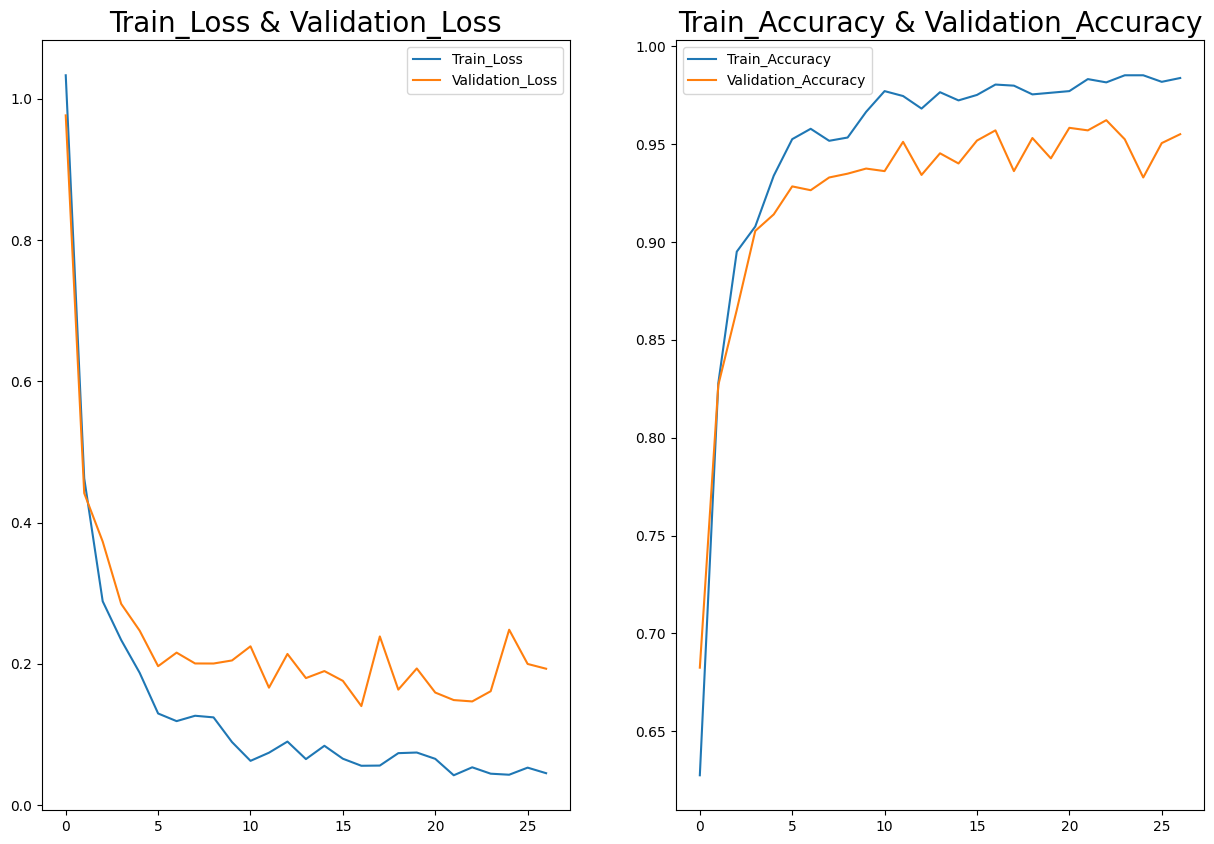

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [ ]:
test_datagen  = ImageDataGenerator(rescale = 1./255)
test_dataset  = test_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset/test',
                                                 target_size = (224,224),                                          class_mode = 'categorical',
                                                 batch_size = 2500)

Found 1279 images belonging to 4 classes.


In [ ]:
X_test,y_test = next(test_dataset)

In [ ]:
score, acc = model.evaluate(X_test,y_test)

40/40 [==============================] - 4s 109ms/step - loss: 1.7351 - accuracy: 0.6943


In [ ]:
print('Test Loss =', score)
print('Test Accuracy =', acc)

Test Loss = 1.7350801229476929
Test Accuracy = 0.694292426109314


In [ ]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions,axis=1)
y_test_ = np.argmax(y_test,axis=1)
df = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})
df

40/40 [==============================] - 4s 43ms/step


,Actual,Prediction
0,3,2
1,3,3
2,3,2
3,0,0
4,2,2
...,...,...
1274,3,3
1275,3,3
1276,2,2
1277,3,3


array([[ 61,   2,  46,  70],
       [  1,   2,   1,   8],
       [  4,   0, 523, 113],
       [ 11,   0, 135, 302]])

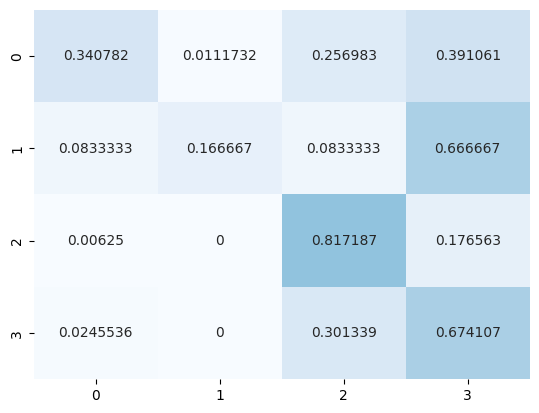

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
CM = confusion_matrix(y_test_,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [ ]:
ClassificationReport = classification_report(y_test_,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.79      0.34      0.48       179
           1       0.50      0.17      0.25        12
           2       0.74      0.82      0.78       640
           3       0.61      0.67      0.64       448

    accuracy                           0.69      1279
   macro avg       0.66      0.50      0.54      1279
weighted avg       0.70      0.69      0.68      1279

